In [2]:
import numpy as np
import pysindy as ps

from scipy.integrate import odeint
from scipy.io import loadmat
from sklearn.linear_model import Lasso

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cm import rainbow

In [3]:
x_0 = np.array([np.pi/2,0,0])  #Initial state of observer in the form [theta_0,theta_dot_0,z]
y_0 = np.array([np.pi/4,0,2])  #Initial state of feature in the form [theta_0,theta_dot_0,z]

In [4]:
dt = .005
t = np.arange(0, 10, dt)

In [5]:
param_1 = 1 #pend param g/l^2

def pend_1(x, t): #Observer System
    return [
        x[1], #theta dot
        -param_1*np.sin(x[0])] #omega dot

x0_1 = [np.pi/2, 0] # Observer Initial Conditions

x_1 = odeint(pend_1, x0_1, t) # Generate measurement data in form [theta, omega]
x_1

array([[ 1.57079633,  0.        ],
       [ 1.57078383, -0.005     ],
       [ 1.57074633, -0.01      ],
       ...,
       [-0.93055719, -1.09305723],
       [-0.93601244, -1.08903933],
       [-0.94144756, -1.08500529]])

In [6]:
param_2 = 2 #pend param g/l^2

def pend_2(x, t): #Feature System
    return [
        x[1], #theta dot
        -param_2*np.sin(x[0])] #omega dot

x0_2 = [np.pi/4, 0] # Observer Initial Conditions

x_2 = odeint(pend_2, x0_2, t) # Generate measurement data in form [theta, omega]
x_2

array([[ 0.78539816,  0.        ],
       [ 0.78538049, -0.00707102],
       [ 0.78532745, -0.01414179],
       ...,
       [ 0.42053228, -0.90722642],
       [ 0.41598598, -0.91128813],
       [ 0.41141947, -0.91530817]])

<ipython-input-7-9dfec5e562ef>:9: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


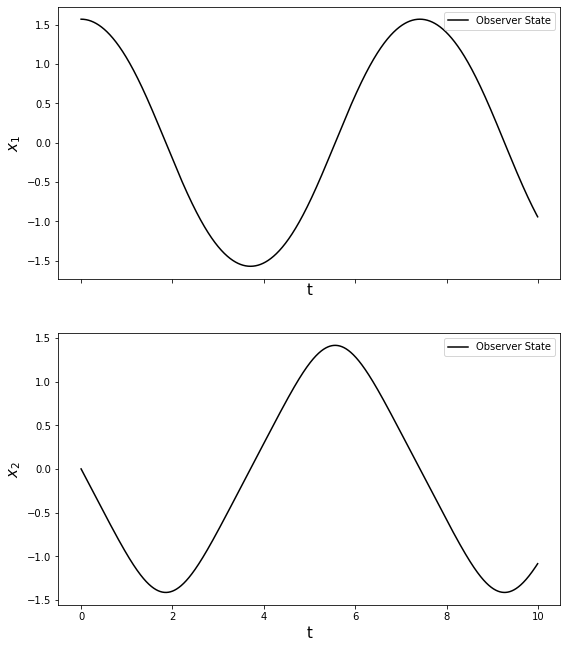

In [7]:
fig, axs = plt.subplots(x_1.shape[1], 1, sharex=True, figsize=(9, 11))
for i in range(x_1.shape[1]):
    axs[i].plot(t, x_1[:, i], 'k', label='Observer State')
    #axs[i].plot(t_test, x_test_sim[:, i], 'r--', label='model simulation')
    axs[i].legend()
    #axs[i].set(xlabel='t', ylabel='$x_{}$'.format(i+1))
    axs[i].set_xlabel('t', fontsize = 15)
    axs[i].set_ylabel('$x_{}$'.format(i+1), fontsize = 15)
fig.show()

<ipython-input-8-bbdefd7eb430>:9: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


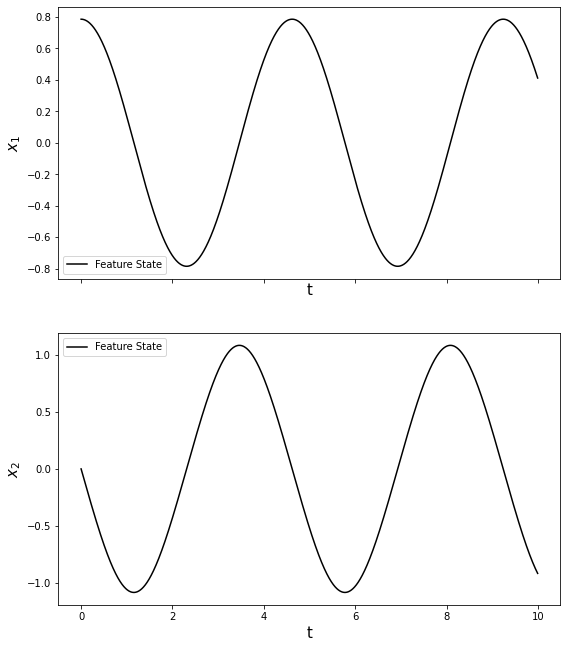

In [8]:
fig, axs = plt.subplots(x_2.shape[1], 1, sharex=True, figsize=(9, 11))
for i in range(x_2.shape[1]):
    axs[i].plot(t, x_2[:, i], 'k', label='Feature State')
    #axs[i].plot(t_test, x_test_sim[:, i], 'r--', label='model simulation')
    axs[i].legend()
    #axs[i].set(xlabel='t', ylabel='$x_{}$'.format(i+1))
    axs[i].set_xlabel('t', fontsize = 15)
    axs[i].set_ylabel('$x_{}$'.format(i+1), fontsize = 15)
fig.show()

In [9]:
del_x = x_2-x_1
del_x

array([[-0.78539816,  0.        ],
       [-0.78540334, -0.00207102],
       [-0.78541887, -0.00414179],
       ...,
       [ 1.35108947,  0.18583081],
       [ 1.35199842,  0.1777512 ],
       [ 1.35286703,  0.16969712]])

In [10]:
differentiation_method = ps.FiniteDifference(order=2)

optimizer = ps.STLSQ(threshold=0.2)
lasso_optimizer = Lasso(alpha=0.001, max_iter=2000, fit_intercept=False)
sr3_optimizer = ps.SR3(threshold=0.1, nu=1)

poly_library = ps.PolynomialLibrary()
fourier_library = ps.FourierLibrary()
identity_library = ps.IdentityLibrary()
combined_library = poly_library + fourier_library + identity_library

model = ps.SINDy(
    differentiation_method=differentiation_method,
    feature_library=combined_library,
    optimizer=sr3_optimizer)

x0' = 0.500 x1 + 0.500 x1
x1' = 1.018 1 + -0.362 x0 + -0.470 x1 + 1.037 x0^2 + 0.120 x0 x1 + -1.468 x1^2 + -0.546 sin(1 x0) + 2.914 cos(1 x0) + 1.510 sin(1 x1) + -4.367 cos(1 x1) + -0.362 x0 + -0.470 x1
Model score: 0.967367


<ipython-input-13-91b065640df9>:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


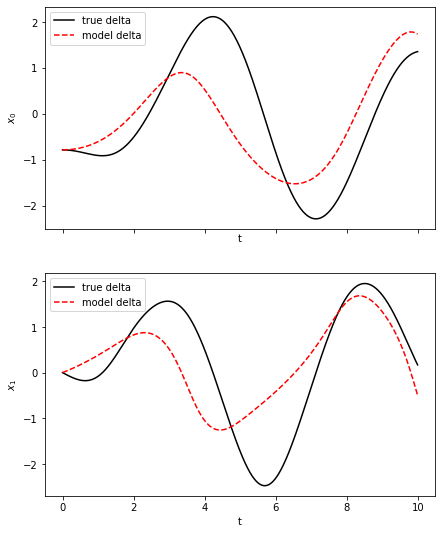

In [13]:
model.fit(del_x, t=dt)
model.print()
print('Model score: %f' % model.score(del_x, t=dt))
del_x0 = [-np.pi/4, 0]

del_x_sim = model.simulate(del_x0, t)

fig, axs = plt.subplots(del_x.shape[1], 1, sharex=True, figsize=(7, 9))
for i in range(del_x.shape[1]):
    axs[i].plot(t, del_x[:, i], 'k', label='true delta')
    axs[i].plot(t, del_x_sim[:, i], 'r--', label='model delta')
    axs[i].legend()
    axs[i].set(xlabel='t', ylabel='$x_{}$'.format(i))

fig.show()